In [55]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
import networkx as nx
import networkx.algorithms.community as nxcom
import datetime as dt

sns.set_theme(style="darkgrid")

## Data

In [56]:
df=pd.read_csv("../data/raw/jazznoir_2015_2022.csv")
df.columns = ['author','created_utc','domain','id','n_comments','text','title','url','date']
df_comments=pd.read_csv("../data/raw/jazznoir_2015_2022_comments.csv")

#convert to datetime
df['date'] = pd.to_datetime(df['date'],unit='s')
df_comments['date'] = pd.to_datetime(df_comments['created'],unit='s')

df_comments['author'].dropna(inplace=True)
df['author'].dropna(inplace=True)
df.drop(df.loc[df['author']=='[deleted]'].index, inplace=True)


df_karma=pd.read_csv("../data/raw/jazznoir_2015_2022_karma.csv")

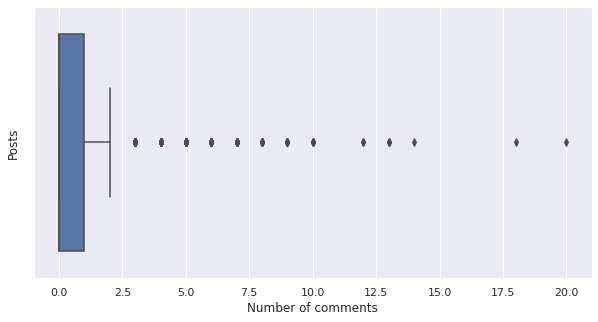

Mean:  0.8295107033639144
Median:  0.0
Max:  20
Min:  0
Std:  1.6950144756064989
Var:  2.8730740725155743


In [57]:
def plot_comments_per_post(df):
    plt.figure(figsize=(10,5))
    ax = sns.boxplot(x=df["n_comments"])
    ax.set(xlabel='Number of comments', ylabel='Posts')
    plt.show()
    print("Mean: ", np.mean(df["n_comments"]))
    print("Median: ", np.median(df["n_comments"]))
    print("Max: ", np.max(df["n_comments"]))
    print("Min: ", np.min(df["n_comments"]))
    print("Std: ", np.std(df["n_comments"]))
    print("Var: ", np.var(df["n_comments"]))

plot_comments_per_post(df)

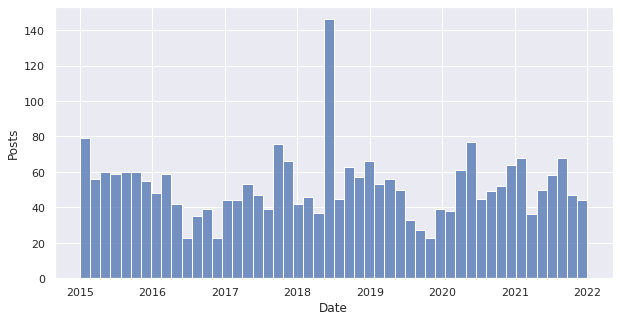

In [58]:
def plot_post_date(df):
    plt.figure(figsize=(10,5))
    ax = sns.histplot(x=df["date"],bins=50)
    ax.set(xlabel='Date', ylabel='Posts')
    plt.show()

plot_post_date(df)

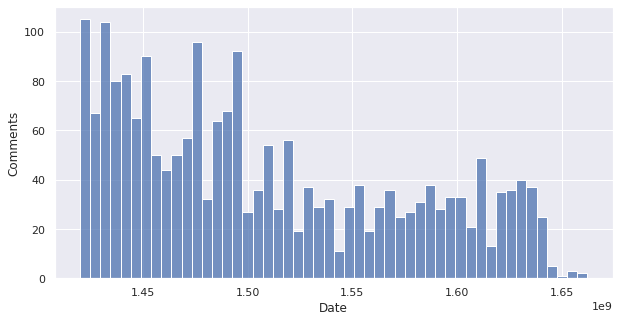

In [59]:
def plot_comments_in_df_comments(df_comments):
    plt.figure(figsize=(10,5))
    ax = sns.histplot(x=df_comments["created"],bins=50)
    ax.set(xlabel='Date', ylabel='Comments')
    plt.show()

plot_comments_in_df_comments(df_comments)

## Graphs

In [60]:
df_all_nodes = pd.DataFrame()
df_all_nodes['author'] = pd.concat([df_comments["author"].drop_duplicates(), df["author"].drop_duplicates()])
df_all_nodes = df_all_nodes.drop_duplicates()
df_all_nodes['author'].dropna(inplace=True)

def find_type(author):
    if author in df["author"].unique():
        if author in df_comments["author"].unique():
            return "both"
        else:
            return "poster"
    else:
        return "commenter"

df_all_nodes["type"] = df_all_nodes["author"].apply(find_type)

#remove float values from df_all_nodes
df_all_nodes = df_all_nodes[df_all_nodes["author"].apply(lambda x: isinstance(x, str))]


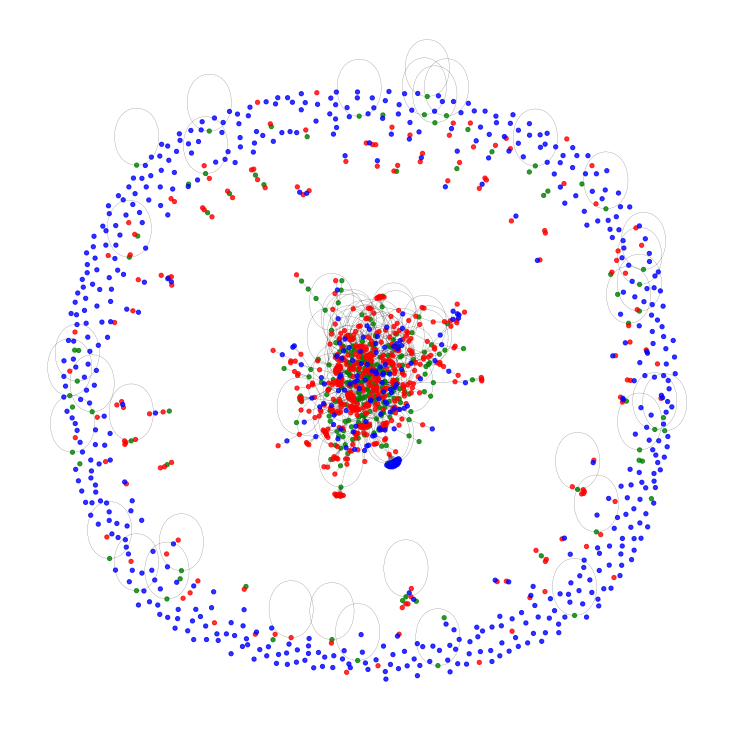

In [61]:
# add nodes from authors
G = nx.Graph()

df_all_nodes["author"].dropna(inplace=True)
G.add_nodes_from(df_all_nodes["author"].loc[df_all_nodes['type']=='both'], type='both')
G.add_nodes_from(df_all_nodes["author"].loc[df_all_nodes['type']=='commenter'], type='commenter')
G.add_nodes_from(df_all_nodes["author"].loc[df_all_nodes['type']=='poster'], type='poster')

color_map = []
for node in G:
    if type(node) == float: print(node)


    if G.nodes[node]['type'] == 'both':
        color_map.append('green')
    elif G.nodes[node]['type'] == 'commenter':
        color_map.append('red')
    else:
        color_map.append('blue')

    for p_id in df_comments.loc[df_comments['author'] == node].parent_id:
        if len(list(p_id)) > 0:
            
            if 't3_' in p_id:
                p_id = p_id.replace('t3_','')
                if p_id in df['id'].unique():
                    if df.loc[df['id'] == p_id].author.values[0] in G.nodes:
                        G.add_edge(node, df.loc[df['id'] == p_id].author.values[0])
            
            elif 't1_' in p_id:
                p_id = p_id.replace('t1_','')
                if p_id in df_comments['id'].unique():
                    if df_comments.loc[df_comments['id'] == p_id].author.values[0] in G.nodes:
                        G.add_edge(node, df_comments.loc[df_comments['id'] == p_id].author.values[0])

# color node
plt.figure(figsize=(10,10))
nx.draw(G, node_color=color_map, with_labels=False, node_size=18,pos=nx.spring_layout(G), width=0.2, alpha=0.8)

In [62]:
# copy graph
G2 = G.copy()

for component in list(nx.connected_components(G2)):
    if len(component)<10:
        for node in component:
            G2.remove_node(node)

# color nodes by type
color_map2 = []
for node in G2:
    if G2.nodes[node]['type'] == 'both':
        color_map2.append('green')
    elif G2.nodes[node]['type'] == 'commenter':
        color_map2.append('red')
    else:
        color_map2.append('blue')


# increase size of nodes depending on degree
node_size = [G2.degree(node)*2+100 for node in G2]


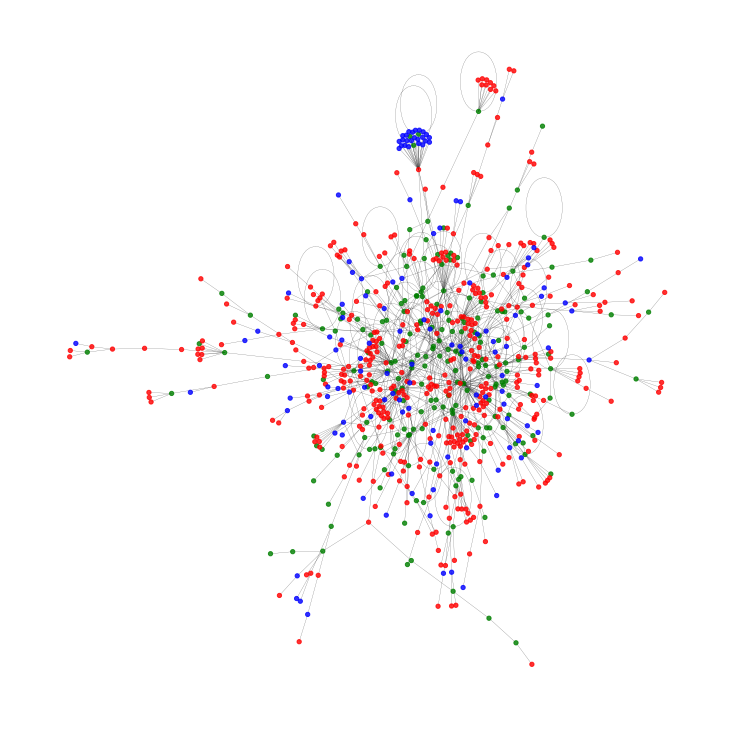

In [63]:
# plot graph
plt.figure(figsize=(10,10))
nx.draw(G2, node_color=color_map2, with_labels=False,node_size=18, pos=nx.spring_layout(G2), width=0.2, alpha=0.8)
plt.show()


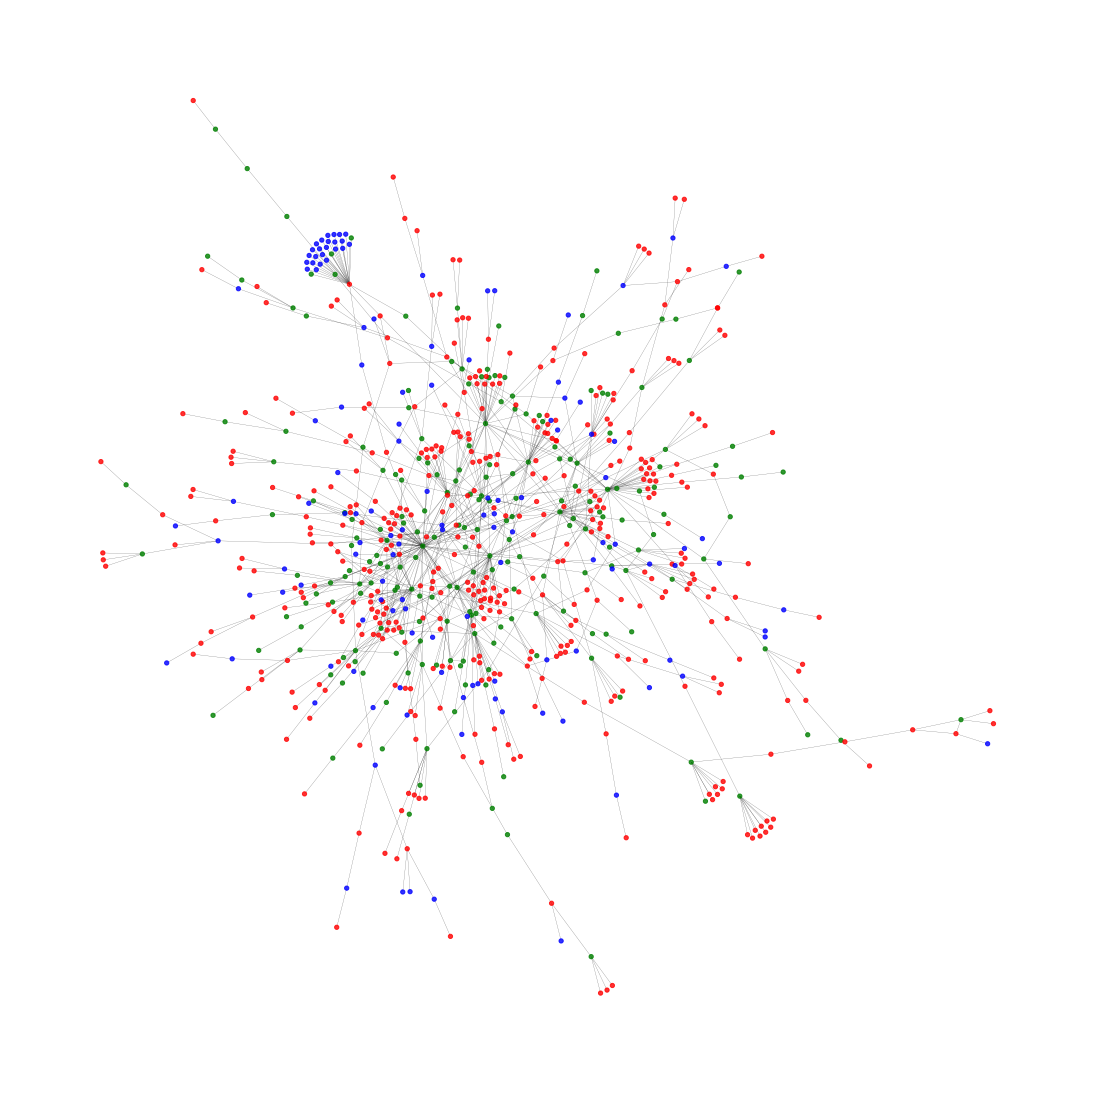

In [64]:
G2.remove_edges_from(nx.selfloop_edges(G2))

# plot graph
plt.figure(figsize=(15,15))
nx.draw(G2, node_color=color_map2, with_labels=False,node_size=18, pos=nx.spring_layout(G2), width=0.2, alpha=0.8)
plt.show()

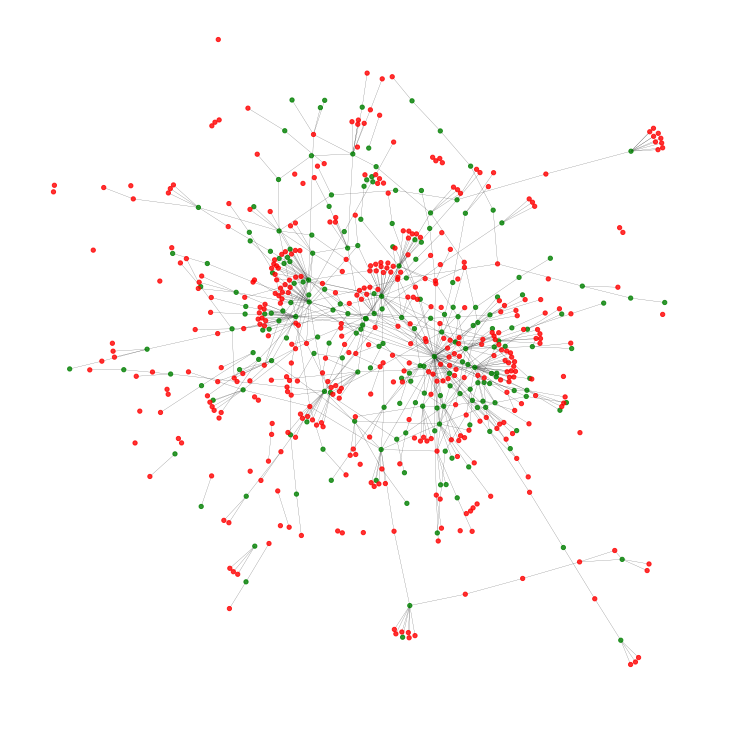

In [65]:
# get poster nodes
posters = [node for node in G2.nodes if G2.nodes[node]['type'] == 'poster']

G3=G2.copy()

G3.remove_nodes_from(posters)

# color nodes by type
color_map3 = []
for node in G3:
    if G3.nodes[node]['type'] == 'both':
        color_map3.append('green')
    elif G3.nodes[node]['type'] == 'commenter':
        color_map3.append('red')
    else:
        color_map3.append('blue')

plt.figure(figsize=(10,10))
nx.draw(G3, node_color=color_map3, with_labels=False,node_size=18, pos=nx.spring_layout(G2), width=0.2, alpha=0.8)
plt.show()


In [66]:
# # plot graph
# fig=plt.figure(figsize=(20,20))

# nx.draw(G2, node_color=color_map2,with_labels=False,node_size=18, pos=nx.spring_layout(G2), width=0.2, alpha=0.8)
# # fig.set_facecolor('grey')
# plt.savefig('graph_test.png', facecolor=fig.get_facecolor(), edgecolor='none')
# plt.show()

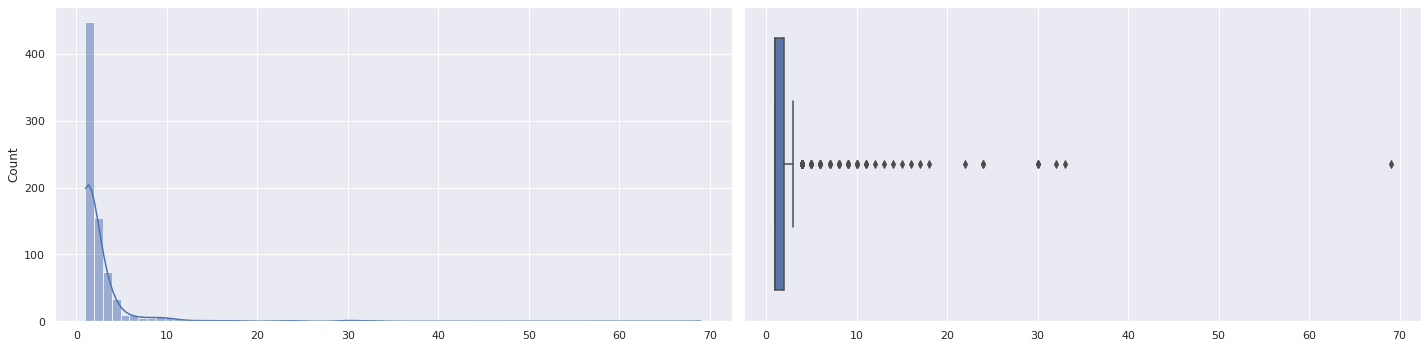

In [67]:
# plot subplots of degrees boxplot and distribution
def plot_degree_distribution(G):
    fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(20,5))
    sns.histplot(x=list(dict(G.degree()).values()),bins=70, ax=ax1,kde=True)
    sns.boxplot(x=list(dict(G.degree()).values()), ax=ax2)
    plt.tight_layout()
    plt.show()

plot_degree_distribution(G2)

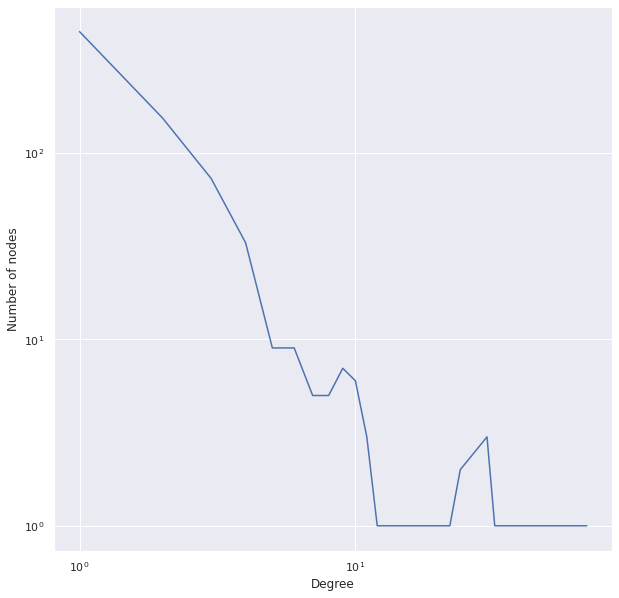

In [68]:
from collections import Counter

plt.figure(figsize=(10,10))
sns.lineplot(x=list(dict(Counter(dict(G2.degree()).values())).keys()), y=list(dict(Counter(dict(G2.degree()).values())).values()))
plt.xscale('log')
plt.xlabel('Degree')
plt.ylabel('Number of nodes')
plt.yscale('log')
plt.show()


## Activity

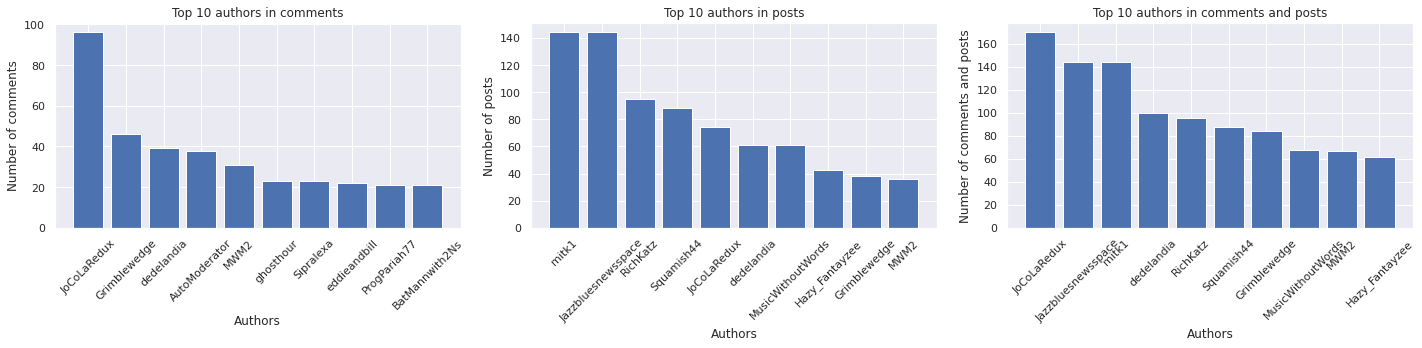

In [69]:
#plot top 10 authors for comments and for posts subplots
fig, axs = plt.subplots(1, 3, figsize=(20,5))
axs[0].bar(x=df_comments["author"].value_counts().head(10).index, height=df_comments["author"].value_counts().head(10).values)
axs[0].set_title("Top 10 authors in comments")
axs[0].set_xlabel("Authors")
axs[0].set_ylabel("Number of comments")
axs[0].tick_params(axis='x', rotation=45)
axs[1].bar(x=df["author"].value_counts().head(10).index, height=df["author"].value_counts().head(10).values)
axs[1].set_title("Top 10 authors in posts")
axs[1].set_xlabel("Authors")
axs[1].set_ylabel("Number of posts")
axs[1].tick_params(axis='x', rotation=45)

df_comment_post=pd.concat([df_comments[['date','author']],df[['date','author']]]).sort_values(by='date')
df_comment_post.dropna(inplace=True)
axs[2].bar(x=df_comment_post["author"].value_counts().head(10).index, height=df_comment_post["author"].value_counts().head(10).values)
axs[2].set_title("Top 10 authors in comments and posts")
axs[2].set_xlabel("Authors")
axs[2].set_ylabel("Number of comments and posts")
axs[2].tick_params(axis='x', rotation=45)
plt.tight_layout()


plt.show()

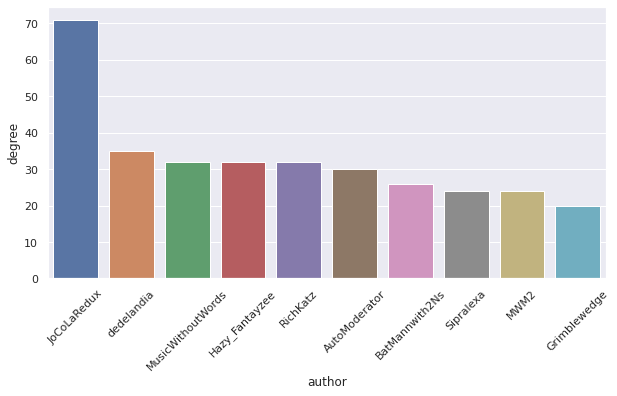

In [70]:
#find top 10 highest degree authors
top_10_authors = sorted(dict(G.degree()).items(), key=lambda x: x[1], reverse=True)[:10]
# plot top_10_authors
plt.figure(figsize=(10,5))
top_10_authors_df = pd.DataFrame(top_10_authors, columns=["author", "degree"])
sns.barplot(x="author", y="degree", data=top_10_authors_df)
# rotate x axis labels
plt.xticks(rotation=45)
plt.show()

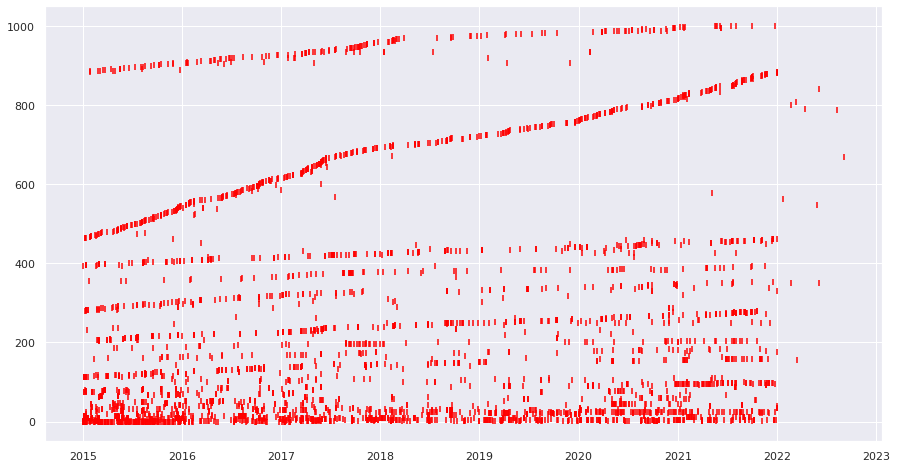

In [71]:
top_authors = sorted(dict(G.degree()).items(), key=lambda x: x[1], reverse=True)[:1000]
top_authors_df = pd.DataFrame(top_authors, columns=["author", "degree"])


plt.figure(figsize=(15,8))
for i in range(len(top_authors_df['author'])):
    test=df_comment_post.loc[df_comment_post['author']==top_authors_df['author'][i]]
    plt.scatter(test['date'], np.ones(len(test))*i,color='red',marker='|')

plt.show()

In [72]:
# average delta time for authors
def delta_time(author):
    df_a=df_comment_post.loc[df_comment_post['author']==author]
    return df_a['date'].max()-df_a['date'].min()

Mean:  195.75520833333334
Median:  0.0
Standard deviation:  445.3617735592866
Min  : 0
Max  : 2542


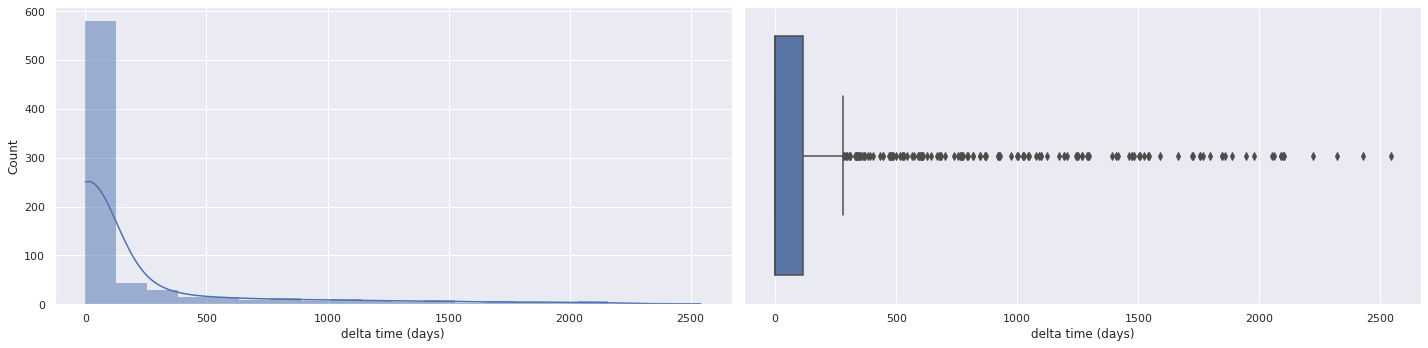

In [73]:
delta_time_for_authors = []

for node in G2.nodes():
    delta_time_for_authors.append(delta_time(node))

delta_time_for_authors = [x.days for x in delta_time_for_authors]

#boxplot delta time + histogram subplots
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(20,5))
sns.histplot(x=delta_time_for_authors, bins=20, ax=ax1, kde=True, alpha=0.5, linewidth=0, label='delta time')
ax1.set_xlabel('delta time (days)')
sns.boxplot(x=delta_time_for_authors, ax=ax2)
ax2.set_xlabel('delta time (days)')
plt.tight_layout()

print("Mean: ", np.mean(delta_time_for_authors))
print("Median: ", np.median(delta_time_for_authors))
print("Standard deviation: ", np.std(delta_time_for_authors))
print('Min  :', np.min(delta_time_for_authors))
print('Max  :', np.max(delta_time_for_authors))

plt.show()

In [74]:
list(df_comments.loc[df_comments['author']=='JoCoLaRedux'].body)[3]

">looking for smokey jazz tunes to listen to.\n\nThat sort of jazz naturally lends itself to the sort of noir vibe this sub was founded on, and has always been our meat & potatoes. For whatever it's worth, we have far more of it than any of us could have hoped for. When we numbered in the hundreds, there was just a few of us scrambling to find content -  MusicWithoutWords and I both spent enough time hunting for appropriate music that could have officially listed it as a hobby - there was always a feeling that anytime soon, the well would dry up. That we're approaching 1000 submissions, the bulk of which would be just that sort of jazz is something we could have never imagined. Hopefully we'll have a good enough ratio of that stuff to keep you coming back.\n\nAs for the other content, we concentrate on music, but the sub has always encouraged other content Here's [an early post](http://www.reddit.com/r/jazznoir/comments/wjycy/film_books_magazines_television_radio_shows/) by our founder

## Robustness

In [75]:
print(nx.average_shortest_path_length(G2))

5.572553373533246


## Communities

In [76]:
communities = nxcom.louvain_communities(G2)
communities = list(communities)
print(len(communities))

25


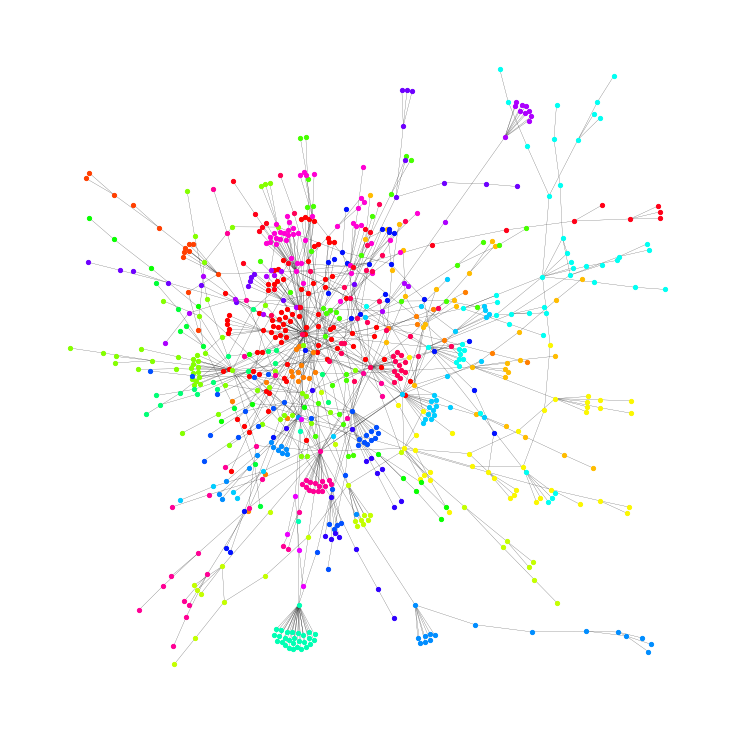

In [77]:
pos = nx.spring_layout(G2) 

plt.figure(figsize=(10,10))
nx.draw(G2, pos, edge_color='k',  with_labels=False,
         font_weight='light', node_size= 1, width= 0.2)


cmap=plt.cm.get_cmap('hsv', len(communities))
#For each community list, draw the nodes, giving it a specific color.
for i in range(len(communities)):
    nx.draw_networkx_nodes(G2, pos, nodelist=communities[i], node_size= 18, node_color=np.array(cmap(i)).reshape(1,-1))

plt.show()

## NLP

In [78]:
# TF IDF
from sklearn.feature_extraction.text import TfidfVectorizer

# create a vectorizer object
vectorizer = TfidfVectorizer(stop_words='english', max_features= 1000) # keep top 1000 terms

#apply the vectorizer to the comments
X = vectorizer.fit_transform(df_comments['body'])

tfidf_df = pd.DataFrame(X.toarray(), columns=vectorizer.get_feature_names_out())

In [79]:
tfidf_df.loc['sum'] = (tfidf_df > 0).sum()
tfidf_df

,10,12,15,1trwocomhg2ekeernyy1ek,2011,2015,2017,22,23,25,...,years,yep,yes,yesterday,york,young,youtu,youtube,zero,échafaud
0,0.0,0.0,0.0,0.0,0.0,0.221169,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.175605,0.0,0.0,0.0
1,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0
2,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0
3,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0
4,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2105,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0
2106,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0
2107,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0
2108,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0


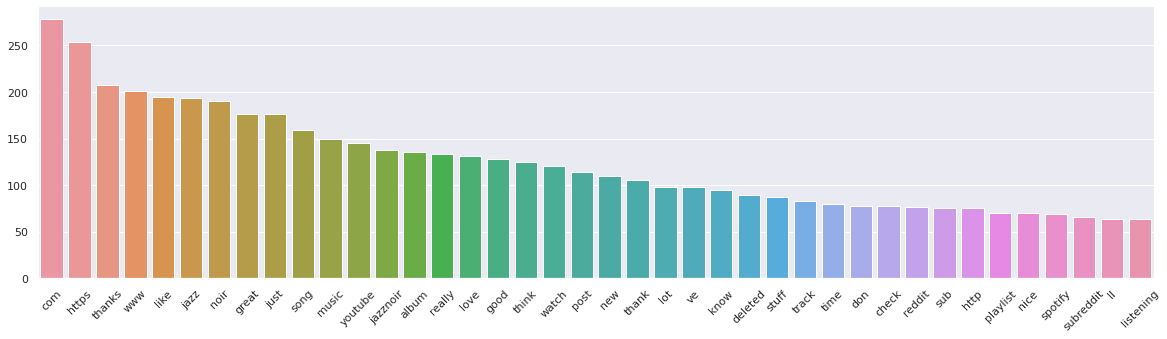

In [80]:
#plot the top 10 words
plt.figure(figsize=(20,5))
sns.barplot(x=tfidf_df.loc['sum'].sort_values(ascending=False).head(40).index, y=tfidf_df.loc['sum'].sort_values(ascending=False).head(40).values)
plt.xticks(rotation=45)
plt.show()

## Karma

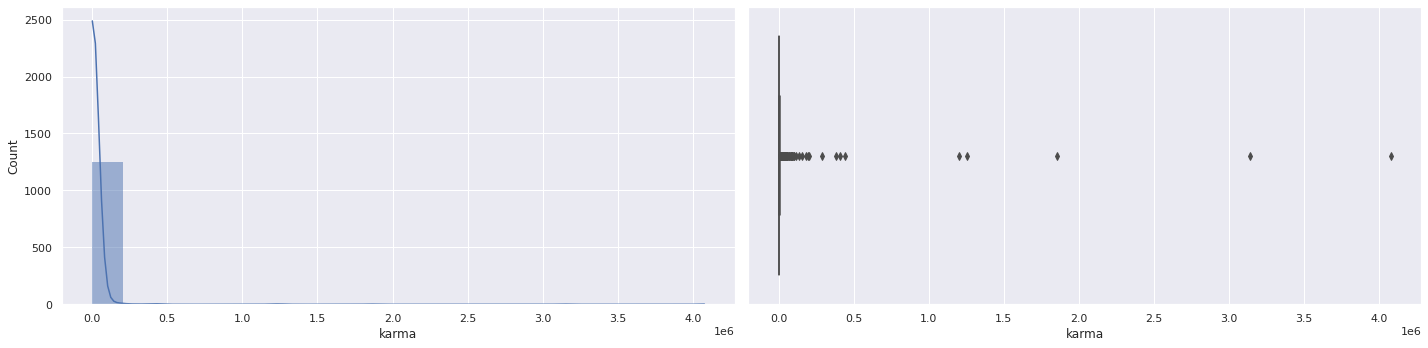

In [81]:
# distribution of karma with boxplot and histogram subplots
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(20,5))
sns.histplot(x=df_karma['karma'], bins=20, ax=ax1, kde=True, alpha=0.5, linewidth=0, label='karma')
ax1.set_xlabel('karma')
sns.boxplot(x=df_karma['karma'], ax=ax2)
ax2.set_xlabel('karma')
plt.tight_layout()
plt.show()

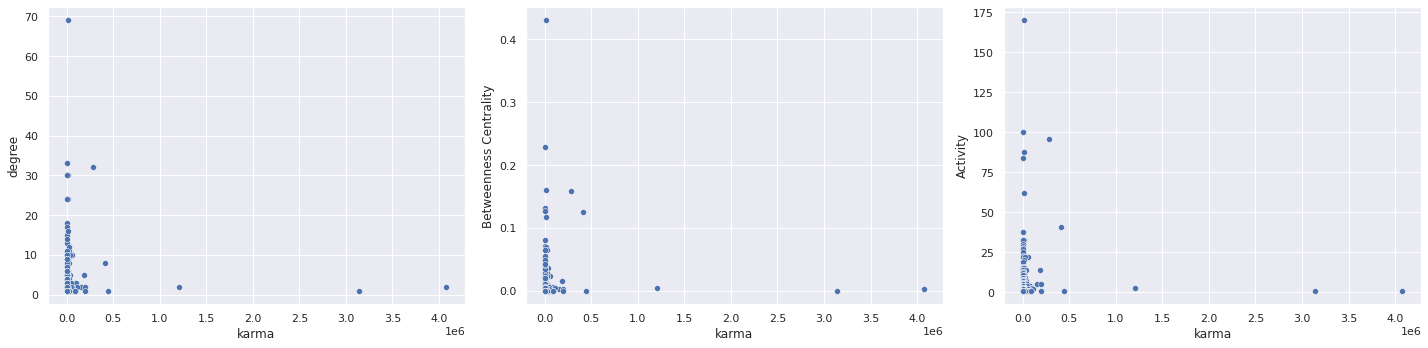

In [110]:
# dict(G2.degree())

#add karma to df_all_nodes
df_authors=df_all_nodes.set_index('author')

df_authors = df_authors.join(df_karma.set_index('author'))
df_authors=pd.DataFrame.from_dict(dict(G2.degree()), orient='index', columns=['degree']).join(df_authors)
df_authors=pd.DataFrame.from_dict(dict(nx.betweenness_centrality(G2)), orient='index', columns=['Betweenness Centrality']).join(df_authors)
df_authors=pd.DataFrame.from_dict(dict(df_comment_post["author"].value_counts()), orient='index', columns=['Activity']).join(df_authors)


# plot subplots. Karma vs degree, karma vs betweenness centrality, karma activity
fig, (ax1, ax2, ax3) = plt.subplots(1, 3, figsize=(20,5))
sns.scatterplot(x=df_authors['karma'], y=df_authors['degree'], ax=ax1)
ax1.set_xlabel('karma')
ax1.set_ylabel('degree')
sns.scatterplot(x=df_authors['karma'], y=df_authors['Betweenness Centrality'], ax=ax2)
ax2.set_xlabel('karma')
ax2.set_ylabel('Betweenness Centrality')
sns.scatterplot(x=df_authors['karma'], y=df_authors['Activity'], ax=ax3)
ax3.set_xlabel('karma')
ax3.set_ylabel('Activity')
plt.tight_layout()
plt.show()

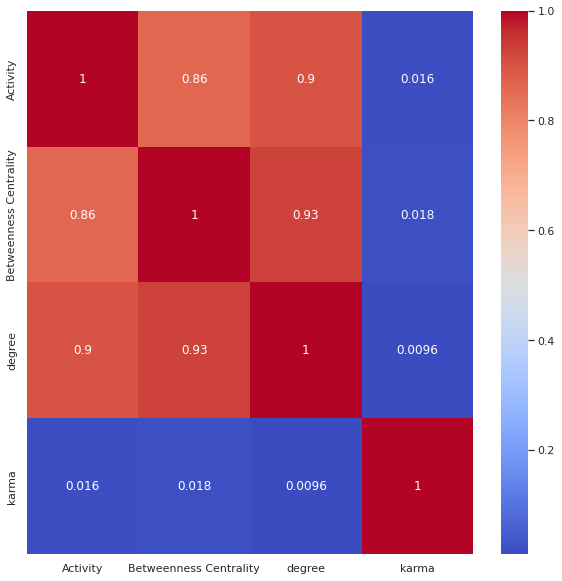

In [112]:
# plot correlation matrix
plt.figure(figsize=(10,10))
sns.heatmap(df_authors.corr(), annot=True, cmap='coolwarm')
plt.show()